# REGRESSION

# Get the data and performing data visualization

In [2]:
import matplotlib
import pylab as plt
import numpy as np
import pandas as pd 

In [3]:
from numpy import random
np.random.seed(42) 
df = pd.read_csv('GHG_Emission.csv',na_values=['NA','?',' ', 'NaN'])#na values may be like NA, ? , ' '
df = df.reindex(np.random.permutation(df.index))  #shuffle data
#permutation of index
#index of pandas, randomly select indices, redindex our inces
df.reset_index(inplace=True, drop=True) # Reset index
 
df[0:5] # Display top five rows

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Classification,Emission Rate (m3/day)
0,588.1,476.3,NaN,NaN,True,NaN,177.8,695.7,0.0,Non Serious,44.432680
1,62.4,666.9,491.7,NaN,False,35.7,139.7,1.0,0.0,Non Serious,29.998576
2,534.4,391.8,NaN,15.690192,True,NaN,177.8,2204.9,0.0,Serious,55.424137
3,298.7,583.0,NaN,NaN,True,35.7,139.7,32683.5,0.0,Serious,53.076994
4,513.8,434.9,2598.2,9.273310,False,NaN,114.3,32683.5,843.0,Serious,50.506939


**REMOVE OUTLIERS**

In [4]:
def outlier_remove(df, n,name):
    """Delete rows for a specified column where values are out of +/- n*sd standard deviations
    df  : Pandas dataframe
    n   : n in the equation 𝑚±𝑛𝜎
    name: Column name
    """
    mean=df[name].mean() # Calclute mean of column
    sd=df[name].std()    # Calclute standard deviation of column
    drop_r = df.index[(mean -n * sd> df[name]) | (mean+n * sd< df[name])]# vertical line is or
    df.drop(drop_r, axis=0, inplace=True)# dropping rows that dont satisfy the code
    df.reset_index(inplace=True, drop=True) # Reset index

# Drop outliers in last column 'OIL Prod. (e3m3/month)'
outlier_remove(df, n=2.5,name='Emission Rate (m3/day)') #based on oil production
df.describe()

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Emission Rate (m3/day)
count,1478.000000,1478.000000,1056.000000,552.000000,1122.000000,1371.000000,1.391000e+03,1478.000000,1478.000000
mean,444.461367,489.886333,1424.863636,31.357534,41.972282,144.075565,5.869690e+04,178.505007,50.291586
std,174.610273,219.042216,943.815439,19.010916,12.636631,26.083016,2.144858e+05,249.017701,9.362271
min,10.900000,1.400000,158.600000,0.231718,13.700000,73.000000,1.000000e+00,0.000000,25.516553
25%,336.475000,369.575000,675.800000,14.533434,35.700000,114.300000,5.752000e+02,0.000000,43.557511
50%,509.850000,494.000000,1104.850000,31.641928,35.700000,139.700000,5.077600e+03,0.000000,50.280065
75%,592.500000,595.275000,1922.625000,44.343357,48.100000,177.800000,3.268350e+04,322.750000,56.625944
max,649.600000,1186.100000,5418.900000,76.894237,107.200000,244.500000,2.273275e+06,1264.000000,74.168289


The outliers have been removed since the number of rows have reduced.

**REGRESSION MODELLING**

In [5]:
df_reg=df.copy()
df_reg.drop(['Classification'], axis=1, inplace=True)# we will use it for regression
df_reg[0:5]

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Emission Rate (m3/day)
0,588.1,476.3,NaN,NaN,True,NaN,177.8,695.7,0.0,44.432680
1,62.4,666.9,491.7,NaN,False,35.7,139.7,1.0,0.0,29.998576
2,534.4,391.8,NaN,15.690192,True,NaN,177.8,2204.9,0.0,55.424137
3,298.7,583.0,NaN,NaN,True,35.7,139.7,32683.5,0.0,53.076994
4,513.8,434.9,2598.2,9.273310,False,NaN,114.3,32683.5,843.0,50.506939


**STRATIFIED SAMPLING FOR EVEN DISTRIBUTION**

In [6]:
df_reg["emission_rate_cat"]=np.ceil(df_reg["Emission Rate (m3/day)"] /17) # 10 leads to most data in categories in 4 arbitary # to divide the data into a better distribution of data
#22 will work as well, just looking for an even distribution
df_reg["emission_rate_cat"].where(df_reg["emission_rate_cat"] < 4, 4, inplace=True) #anything more than 4 assign to 4
#any number will work, 4 is generally chosen, bigger the # more the computation time
df_reg[0:4]

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Emission Rate (m3/day),emission_rate_cat
0,588.1,476.3,NaN,NaN,True,NaN,177.8,695.7,0.0,44.432680,3.0
1,62.4,666.9,491.7,NaN,False,35.7,139.7,1.0,0.0,29.998576,2.0
2,534.4,391.8,NaN,15.690192,True,NaN,177.8,2204.9,0.0,55.424137,4.0
3,298.7,583.0,NaN,NaN,True,35.7,139.7,32683.5,0.0,53.076994,4.0


In [8]:
def histplt (val,bins,title,xlabl,xlimt,axt=None): #python function
    """ Function for histogram plotting"""
    from matplotlib.offsetbox import AnchoredText
    
    ax1 = axt or plt.axes()# left or right plot
    val=np.array(val) # values in the plot
    plt.hist(val, bins=bins,ec='black')      
    n=len(val) # number of values in the plot
    Mean=np.mean(val)
    SD=np.sqrt(np.var(val))
    Max=np.amax(val)
    Min=np.amin(val)
    txt='n=%.0f \n $\mu$=%.1f \n $\sigma$=%.1f \n Max=%.1f \n Min=%.1f'
    anchored_text = AnchoredText(txt %(n,Mean,SD,Max,Min), loc=0)
    ax1.add_artist(anchored_text)
    plt.title(title,fontsize=font['size']*1.25)   
    plt.xlabel(xlabl,fontsize=font['size'])            
    plt.ylabel('Frequency',fontsize=font['size'])
    plt.xlim(xlimt)
    ax1.grid(linewidth='0.35')

Text(0, 0.5, 'Frequency')

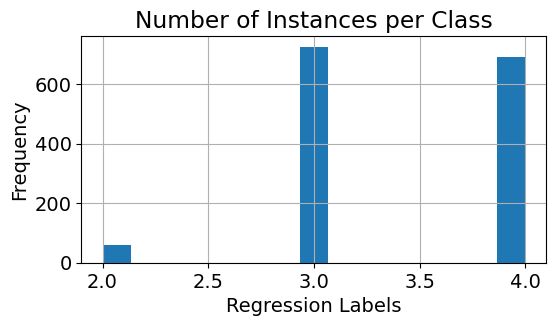

In [9]:
# Plot histogram of categories of entire 
font = {'size'   : 14}
matplotlib.rc('font', **font)

fig = plt.subplots(figsize=(6, 3), dpi= 100, facecolor='w', edgecolor='k')


df_reg["emission_rate_cat"].hist(bins=15)
plt.title("Number of Instances per Class")
plt.xlabel("Regression Labels")
plt.ylabel("Frequency")
#plt.xlimt(0.68,4.3)


#histplt(df_reg["emission_rate_cat"],bins=15,title='Number of Instances per Class ',xlabl='Regression Labels',
     #   xlimt=(0.68,4.3))# since x or number of categoreies is from 0 to 4

Entire data has been split into 4 category where the split is equally distributed in two categories.


In [10]:
df_reg['emission_rate_cat'].value_counts()

3.0    726
4.0    691
2.0     61
Name: emission_rate_cat, dtype: int64

COMMENT

The distribution of data has the following regression labels:

Regression Label 1 - 0% distribution   

Regression Label 2 - 4.1% distribution

Regression Label 3 - 49.1% distribution

Regression Label 4 - 46.8% distribution

**CATEGORIES HAVE CREATED TO SPLIT DATA INTO TEST AND TRAIN**

**SPLITTING TRAINING AND TESTING DATA BASED ON EMISSIONS RATE CATEGORY CREATED**

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit #from sky learn used to divide data into data and training

spt = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# 20 % is test and put some random # otherwise data will chnge
# n_split as once as test and traing data set
#n_split =2 is good for cross validation
for train_idx, test_idx in spt.split(df_reg, df_reg["emission_rate_cat"]): #split ratio of this data and in these categories
    train_set_strat = df_reg.loc[train_idx]
    test_set_strat = df_reg.loc[test_idx]

In [12]:
train_set_strat

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Emission Rate (m3/day),emission_rate_cat
478,294.3,548.7,2504.7,47.479024,False,NaN,177.8,84776.5,0.0,51.237935,4.0
669,611.4,448.0,870.7,19.626487,False,48.7,177.8,10270.5,0.0,45.630606,3.0
1327,407.2,176.2,3269.1,NaN,True,35.7,139.7,23327.1,533.0,64.327602,4.0
962,480.2,478.5,1102.3,NaN,True,NaN,114.3,138.0,0.0,47.891883,3.0
56,379.7,638.8,1953.6,48.966279,True,35.7,114.3,59959.4,616.0,54.767542,4.0
...,...,...,...,...,...,...,...,...,...,...,...
992,385.7,615.9,603.3,NaN,True,NaN,114.3,54822.2,323.0,61.370796,4.0
1156,604.5,483.0,610.0,NaN,True,53.6,177.8,32683.5,0.0,52.178626,4.0
855,601.1,517.9,NaN,NaN,True,48.1,177.8,851.4,0.0,61.319530,4.0
958,348.7,697.9,600.2,NaN,True,81.1,177.8,15003.3,438.0,64.793491,4.0


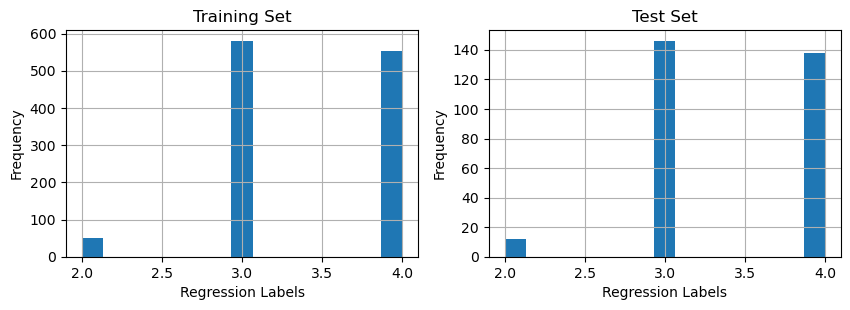

In [13]:
font = {'size'   : 10}
matplotlib.rc('font', **font)

fig = plt.subplots(figsize=(10, 3), dpi= 100, facecolor='w', edgecolor='k')

ax1=plt.subplot(1,2,1)
train_set_strat['emission_rate_cat'].hist(bins=15)
plt.title("Training Set")
plt.xlabel("Regression Labels")
plt.ylabel("Frequency")

ax2=plt.subplot(1,2,2) 
test_set_strat['emission_rate_cat'].hist(bins=15)
plt.title("Test Set")
plt.xlabel("Regression Labels")
plt.ylabel("Frequency")
plt.show()

**TRAINING DATA STRATIFIED SAMPLING**

In [14]:
train_set_strat['emission_rate_cat'].value_counts()

3.0    580
4.0    553
2.0     49
Name: emission_rate_cat, dtype: int64

COMMENT

The distribution of training data has the following regression labels:

Regression Label 1 - 0% distribution 

Regression Label 2 - 4.1% distribution

Regression Label 3 - 49.1% distribution

Regression Label 4 - 46.8% distribution

**TEST DATA STRATIFIED SAMPLING**

In [15]:
test_set_strat['emission_rate_cat'].value_counts()

3.0    146
4.0    138
2.0     12
Name: emission_rate_cat, dtype: int64

The distribution of testing data has the following regression labels:

Regression Label 1 - 0% distribution   

Regression Label 2 - 4.1% distribution

Regression Label 3 - 49.3% distribution

Regression Label 4 - 46.6% distribution

The distribution of trainnig and testing data is almost the same as the original data.

**Removing the emission_rate_cat**

The column - emission_rate_cat that was created for stratified sampling has now been deleted as it is no longer needed

In [16]:
for dataset in (train_set_strat, test_set_strat):
    dataset.drop('emission_rate_cat', axis=1, inplace=True)
    dataset.reset_index(inplace=True, drop=True) # Reset index

In [17]:
train_set_strat

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Emission Rate (m3/day)
0,294.3,548.7,2504.7,47.479024,False,NaN,177.8,84776.5,0.0,51.237935
1,611.4,448.0,870.7,19.626487,False,48.7,177.8,10270.5,0.0,45.630606
2,407.2,176.2,3269.1,NaN,True,35.7,139.7,23327.1,533.0,64.327602
3,480.2,478.5,1102.3,NaN,True,NaN,114.3,138.0,0.0,47.891883
4,379.7,638.8,1953.6,48.966279,True,35.7,114.3,59959.4,616.0,54.767542
...,...,...,...,...,...,...,...,...,...,...
1177,385.7,615.9,603.3,NaN,True,NaN,114.3,54822.2,323.0,61.370796
1178,604.5,483.0,610.0,NaN,True,53.6,177.8,32683.5,0.0,52.178626
1179,601.1,517.9,NaN,NaN,True,48.1,177.8,851.4,0.0,61.319530
1180,348.7,697.9,600.2,NaN,True,81.1,177.8,15003.3,438.0,64.793491


Now setting emission Rate (m3/day) as target in both X and y tarining dataset.

In [18]:
# Note that drop() creates a copy and does not affect train_set_strat
X_train = train_set_strat.drop("Emission Rate (m3/day)", axis=1)# remove target
y_train = train_set_strat["Emission Rate (m3/day)"].values# only taget values

In [19]:
X_train

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,294.3,548.7,2504.7,47.479024,False,NaN,177.8,84776.5,0.0
1,611.4,448.0,870.7,19.626487,False,48.7,177.8,10270.5,0.0
2,407.2,176.2,3269.1,NaN,True,35.7,139.7,23327.1,533.0
3,480.2,478.5,1102.3,NaN,True,NaN,114.3,138.0,0.0
4,379.7,638.8,1953.6,48.966279,True,35.7,114.3,59959.4,616.0
...,...,...,...,...,...,...,...,...,...
1177,385.7,615.9,603.3,NaN,True,NaN,114.3,54822.2,323.0
1178,604.5,483.0,610.0,NaN,True,53.6,177.8,32683.5,0.0
1179,601.1,517.9,NaN,NaN,True,48.1,177.8,851.4,0.0
1180,348.7,697.9,600.2,NaN,True,81.1,177.8,15003.3,438.0


In [20]:
y_train

array([51.23793486, 45.63060645, 64.32760219, ..., 61.31952954,
       64.79349141, 43.89262468])

The target column -Emission Rate (m3/day) has been removed from the X_train datatset
The target column -Emission Rate (m3/day) has been set as the the y_train datatset

# DATA VISUALIZATION

Coverting all text to number in the data.

In [72]:
X_train['Abandoned (True/False)']=X_train['Abandoned (True/False)'].replace(False, 0) # Replace False with 0

X_train['Abandoned (True/False)']=X_train['Abandoned (True/False)'].replace(True, 1)

In [73]:
X_train

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,294.3,548.7,2504.7,47.479024,0.0,NaN,177.8,84776.5,0.0
1,611.4,448.0,870.7,19.626487,0.0,48.7,177.8,10270.5,0.0
2,407.2,176.2,3269.1,NaN,1.0,35.7,139.7,23327.1,533.0
3,480.2,478.5,1102.3,NaN,1.0,NaN,114.3,138.0,0.0
4,379.7,638.8,1953.6,48.966279,1.0,35.7,114.3,59959.4,616.0
...,...,...,...,...,...,...,...,...,...
1177,385.7,615.9,603.3,NaN,1.0,NaN,114.3,54822.2,323.0
1178,604.5,483.0,610.0,NaN,1.0,53.6,177.8,32683.5,0.0
1179,601.1,517.9,NaN,NaN,1.0,48.1,177.8,851.4,0.0
1180,348.7,697.9,600.2,NaN,1.0,81.1,177.8,15003.3,438.0


**CORRELATION MATRIX**

In [74]:
corr_matrix=X_train.corr() #data is Oil_Prod
corr_matrix

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
X Coordinate (km),1.000000,-0.494075,0.068508,0.041788,0.026718,0.001398,0.158294,0.015402,0.043883
Y Coordinate (km),-0.494075,1.000000,-0.069223,0.009084,-0.052023,0.229480,0.145616,0.006670,0.007067
Measured Depth (m),0.068508,-0.069223,1.000000,0.430259,0.237139,-0.019581,0.028805,0.362970,0.451046
Deviation (deg),0.041788,0.009084,0.430259,1.000000,0.131768,-0.007176,0.024468,0.334734,0.292734
Abandoned (True/False),0.026718,-0.052023,0.237139,0.131768,1.000000,-0.042870,-0.030663,0.114492,0.178240
Surface-Casing Weight (kg/m),0.001398,0.229480,-0.019581,-0.007176,-0.042870,1.000000,0.745228,-0.045194,-0.042497
Production-Casing Size (mm),0.158294,0.145616,0.028805,0.024468,-0.030663,0.745228,1.000000,0.020703,-0.002146
Cumulative GAS Prod. (e3m3),0.015402,0.006670,0.362970,0.334734,0.114492,-0.045194,0.020703,1.000000,0.159453
Month Well Spudded,0.043883,0.007067,0.451046,0.292734,0.178240,-0.042497,-0.002146,0.159453,1.000000


Here we observe strong positive linear coorelation between the following
features ranked in the order of highest to lowest:
- Production-Casing Size (mm) and Surface-Casing Weight (kg/m)


Here we observe strong negative linear coorelation between the following
features ranked in the order of highest to lowest:
- Y Coordinate (km)and  X Coordinate (km)


In [75]:
corr_matrix["Measured Depth (m)"].sort_values(ascending=False)

Measured Depth (m)              1.000000
Month Well Spudded              0.451046
Deviation (deg)                 0.430259
Cumulative GAS Prod. (e3m3)     0.362970
Abandoned (True/False)          0.237139
X Coordinate (km)               0.068508
Production-Casing Size (mm)     0.028805
Surface-Casing Weight (kg/m)   -0.019581
Y Coordinate (km)              -0.069223
Name: Measured Depth (m), dtype: float64

Measured Depth, Month Well Spuded, Deviation, followed by Cumulative GAS Prod. (e3m3) have the strongest positive correlation

In [26]:
def corr_bar(df):#python function is creted
    """Plot correlation bar with the pair of atrribute with last column"""
    corr=df.corr()#ft.correlation
    Colms_sh=list(list(corr.columns))# list of column
    coefs=corr.values[:,-1][:-1]
    names=Colms_sh[:-1]
    r_ = pd.DataFrame( { 'coef': coefs, 'positive': coefs>=0  }, index = names )
    r_ = r_.sort_values(by=['coef'])
    r_['coef'].plot(kind='barh', color=r_['positive'].map({True: 'b', False: 'r'}))
    plt.xlabel('Correlation Coefficient',fontsize=6)
    plt.vlines(x=0,ymin=-0.5, ymax=10, color = 'k',linewidth=0.8,linestyle="dashed")
    plt.show()

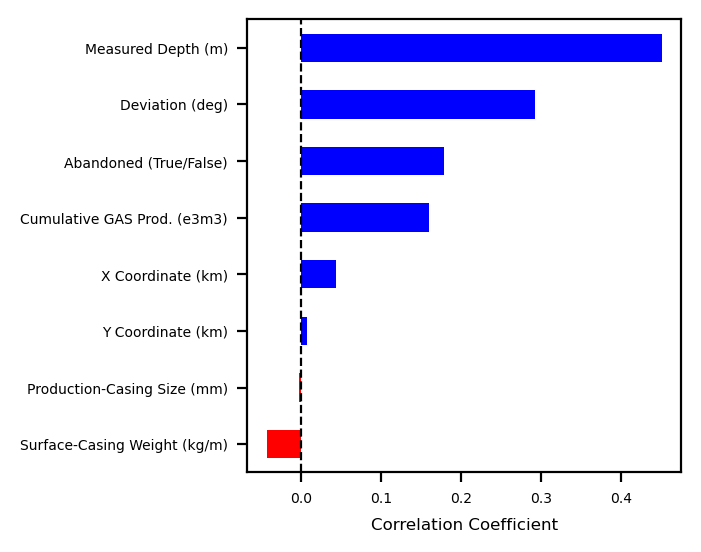

In [76]:
font = {'size'   : 5}
matplotlib.rc('font', **font)
ax1 = plt.subplots(figsize=(2.8, 3), dpi= 200, facecolor='w', edgecolor='k')#backcolour white and edge colour black

# Plot correlations of attributes with the last column
corr_bar(X_train) # make the plot of this function

Measured Depth, Deviation, followed by abandoned have the strongest positive correlation.
Production -Casing Weight and Surface-Casing Weight have a negative coorelation.

**CROSS PLOT**

In [77]:
columns=['X Coordinate (km)','Y Coordinate (km)','Measured Depth (m)','Deviation (deg)', 'Surface-Casing Weight (kg/m)', 'Production-Casing Size (mm)', 'Cumulative GAS Prod. (e3m3)', 'Month Well Spudded', 'Abandoned (True/False)' ]# names of columns for which u want to make a histogram


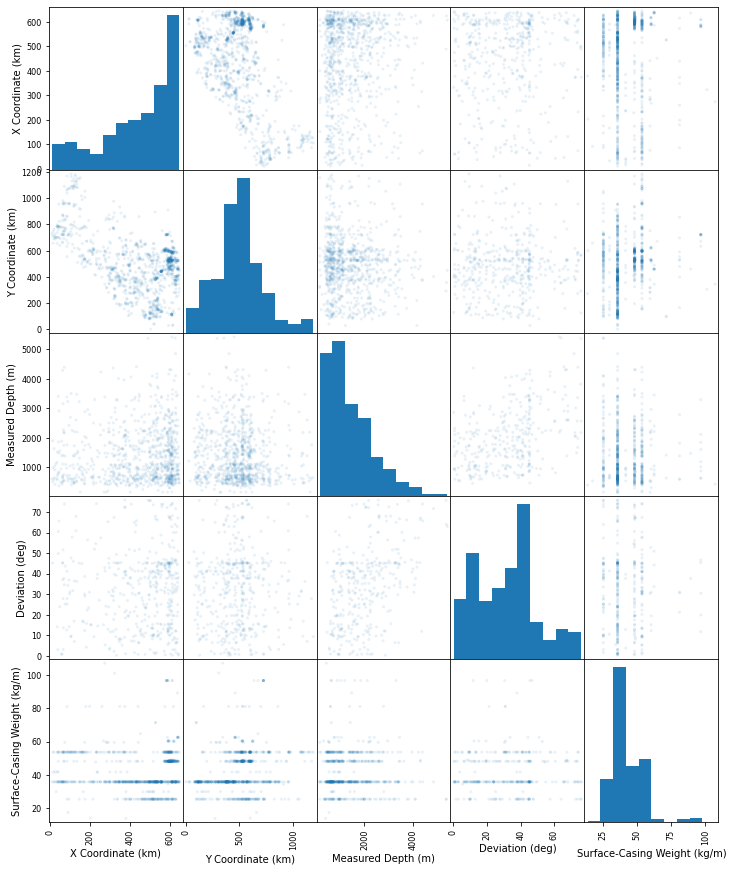

In [29]:
font = {'size'   : 10}
matplotlib.rc('font', **font)
from pandas.plotting import scatter_matrix # histrogram matrix diagonal u have a histogram of each variable

scatter_matrix(X_train[columns[0:5]],figsize=(12, 15),alpha=0.1) 
plt.show()

In [78]:
def CrossPlot (x,y,xlabl,ylabl,axt=None):
    '''Cross plot between two variables'''
    from matplotlib.offsetbox import AnchoredText
    ax1 = axt or plt.axes()
    x=np.array(x)
    y=np.array(y)    
    n_x=len(x) #number of varibles
    Mean_x=np.mean(x)
    SD_x=np.sqrt(np.var(x)) 
    n_y=len(y)
    Mean_y=np.mean(y)
    SD_y=np.sqrt(np.var(y)) 
    corr=np.corrcoef(x,y)
    plt.plot(x,y,'ro',markersize=2,alpha=0.08)
    txt='$\\rho_{XY}$=%.3f \n $n$=%.0f \n $\mu_{X}$=%.1f \n $\sigma_{X}$=%.1f \n '
    txt+=' $\mu_{Y}$=%.1f \n $\sigma_{Y}$=%.1f'
    anchored_text = AnchoredText(txt %(corr[1,0], n_x,Mean_x,SD_x,Mean_y,SD_y),loc=3)
   
    ax1.add_artist(anchored_text)
    plt.xlabel(xlabl,fontsize=font['size'])            
    plt.ylabel(ylabl,fontsize=font['size'])

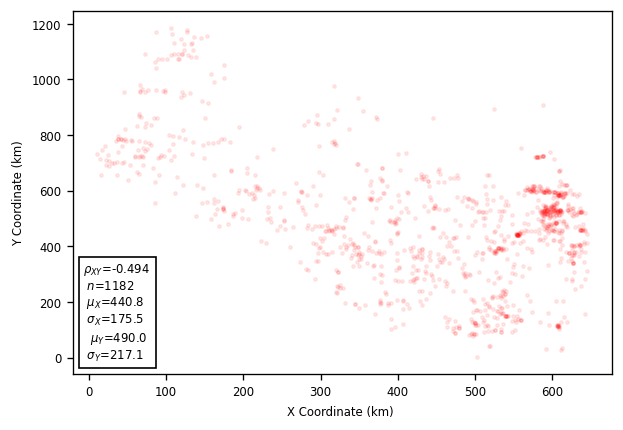

In [79]:
font = {'size'   :7 }
matplotlib.rc('font', **font)
fig=plt.figure(figsize=(12.75,4), dpi= 120, facecolor='w', edgecolor='k')

ax1 = plt.subplot(1,2,1)
CrossPlot (x=X_train['X Coordinate (km)'],y=X_train['Y Coordinate (km)'],xlabl='X Coordinate (km) ',
           ylabl='Y Coordinate (km)',axt=ax1)

In [80]:
def CrossPlot (x,y,xlabl,ylabl,axt=None):
    '''Cross plot between two variables'''
    from matplotlib.offsetbox import AnchoredText
    ax1 = axt or plt.axes()
    x=np.array(x)
    y=np.array(y)    
    n_x=len(x) #number of varibles
    Mean_x=np.mean(x)
    SD_x=np.sqrt(np.var(x)) 
    n_y=len(y)
    Mean_y=np.mean(y)
    SD_y=np.sqrt(np.var(y)) 
    corr=np.corrcoef(x,y)
    plt.plot(x,y,'ro',markersize=2,alpha=0.08)
    txt='$\\rho_{XY}$=%.3f \n $n$=%.0f \n $\mu_{X}$=%.1f \n $\sigma_{X}$=%.1f \n '
    txt+=' $\mu_{Y}$=%.1f \n $\sigma_{Y}$=%.1f'
    anchored_text = AnchoredText(txt %(corr[1,0], n_x,Mean_x,SD_x,Mean_y,SD_y),loc=10)
   
    ax1.add_artist(anchored_text)
    plt.xlabel(xlabl,fontsize=font['size'])            
    plt.ylabel(ylabl,fontsize=font['size']) 


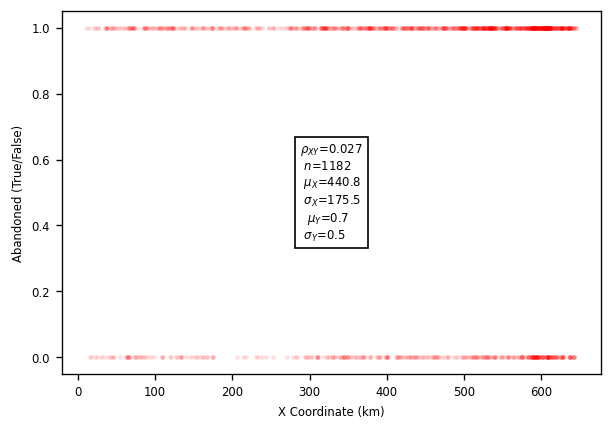

In [81]:
font = {'size'   :7 }
matplotlib.rc('font', **font)
fig=plt.figure(figsize=(12.75,4), dpi= 120, facecolor='w', edgecolor='k')

ax2 = plt.subplot(1,2,2)
CrossPlot (x=X_train['X Coordinate (km)'],y=X_train['Abandoned (True/False)'],xlabl='X Coordinate (km)',
           ylabl='Abandoned (True/False)',axt=ax2)

As expected both X and Y coordinate are weakly negative correlation. 
On the other hand, both Abandoned(True/False) and X coordinate are weak positive correlation.
The mean and standard deviation of of the plot between X and Y coordinate is high owing to the high values.
On the contary, the standard deviation and mean of abandoned wells is less than 1 since the values  its value
ranages from 0 to 1.

**HISTOGRAM**

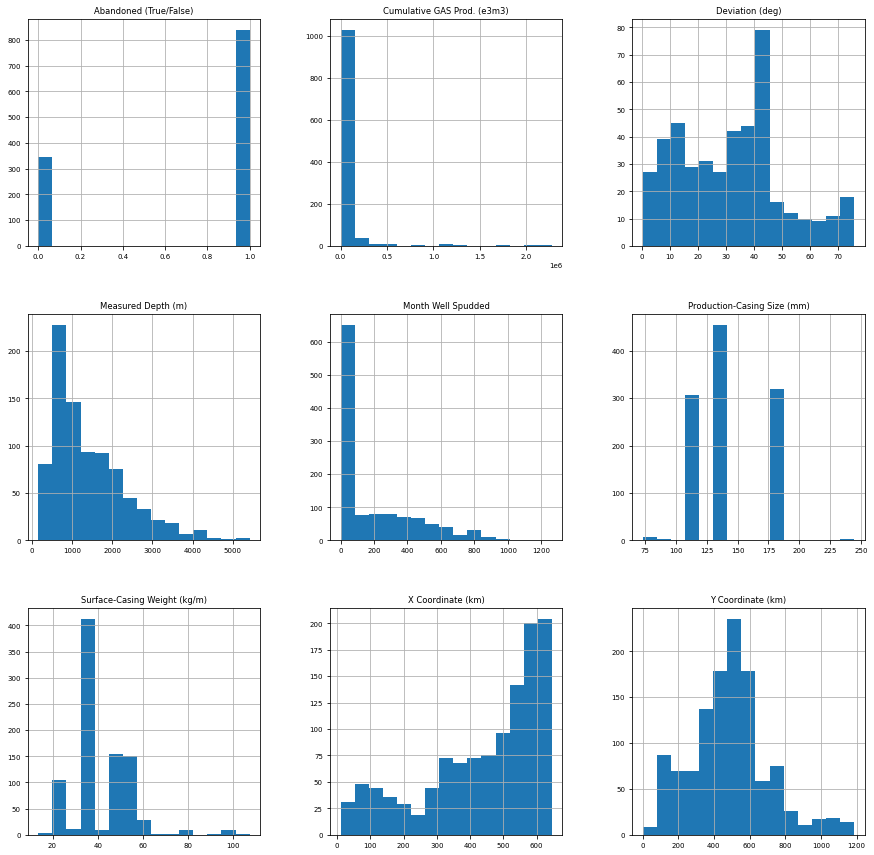

In [34]:
columns=columns=['X Coordinate (km)','Y Coordinate (km)','Measured Depth (m)','Deviation (deg)', 'Surface-Casing Weight (kg/m)', 'Production-Casing Size (mm)', 'Cumulative GAS Prod. (e3m3)', 'Month Well Spudded', 'Abandoned (True/False)' ]# names of columns for which u want to make a histogram
# names of columns for which u want to make a histogram
X_train[columns].hist(bins=15, layout=(3, 3), figsize=(15,15)) # 3 rows and 3 columns # figure size is the spread of the histogram
plt.show()

Here we observe that Emission Rate, Deviation (deg), Measured Depth and Y coordinate have a normal distibution. 
X-Coordinate is negatively skewed distribution.
Cumulative Gas, measured Depth, Month Well Spudded are positively skewed distribution.
The histograms are very similar to the intial dataset,and not much has changed in them.

Here are better histograms of training data

In [83]:
def histplt (val,bins,title,xlabl,xlimt,axt=None): #python function
    """ Function for histogram plotting"""
    from matplotlib.offsetbox import AnchoredText
    
    ax1 = axt or plt.axes()# left or right plot
    val=np.array(val) # values in the plot
    plt.hist(val, bins=bins,ec='black')      
    n=len(val) # number of values in the plot
    Mean=np.mean(val)
    SD=np.sqrt(np.var(val))
    Max=np.amax(val)
    Min=np.amin(val)
    txt='n=%.0f \n $\mu$=%.1f \n $\sigma$=%.1f \n Max=%.1f \n Min=%.1f'
    anchored_text = AnchoredText(txt %(n,Mean,SD,Max,Min), loc=2)
    ax1.add_artist(anchored_text)
    plt.title(title,fontsize=font['size']*1.25)   
    plt.xlabel(xlabl,fontsize=font['size'])            
    plt.ylabel('Frequency',fontsize=font['size'])
    plt.xlim(xlimt)
    ax1.grid(linewidth='0.35')

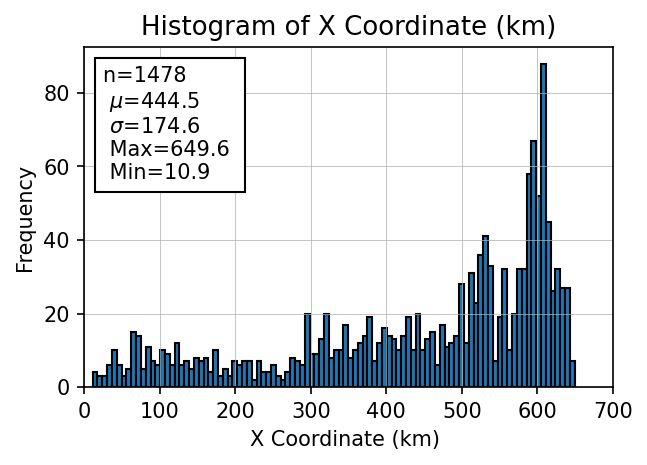

In [84]:
font = {'size'   : 10} #10 changes the font size of#s in ur plot
matplotlib.rc('font', **font)
fig = plt.subplots(figsize=(10, 3), dpi= 150, facecolor='w', edgecolor='k')#dpi makesplot small, dpi=100 to begin with

ax1=plt.subplot(1,2,1) 
val=df['X Coordinate (km)']
histplt(val,bins=100,title='Histogram of X Coordinate (km)',xlabl='X Coordinate (km) ',xlimt=(0,700),axt=ax1)
#hidplt function is above


In [85]:
def histplt (val,bins,title,xlabl,xlimt,axt=None): #python function
    """ Function for histogram plotting"""
    from matplotlib.offsetbox import AnchoredText
    
    ax1 = axt or plt.axes()# left or right plot
    val=np.array(val) # values in the plot
    plt.hist(val, bins=bins,ec='black')      
    n=len(val) # number of values in the plot
    Mean=np.mean(val)
    SD=np.sqrt(np.var(val))
    Max=np.amax(val)
    Min=np.amin(val)
    txt='n=%.0f \n $\mu$=%.1f \n $\sigma$=%.1f \n Max=%.1f \n Min=%.1f'
    anchored_text = AnchoredText(txt %(n,Mean,SD,Max,Min), loc=1)
    ax1.add_artist(anchored_text)
    plt.title(title,fontsize=font['size']*1.25)   
    plt.xlabel(xlabl,fontsize=font['size'])            
    plt.ylabel('Frequency',fontsize=font['size'])
    plt.xlim(xlimt)
    ax1.grid(linewidth='0.35')

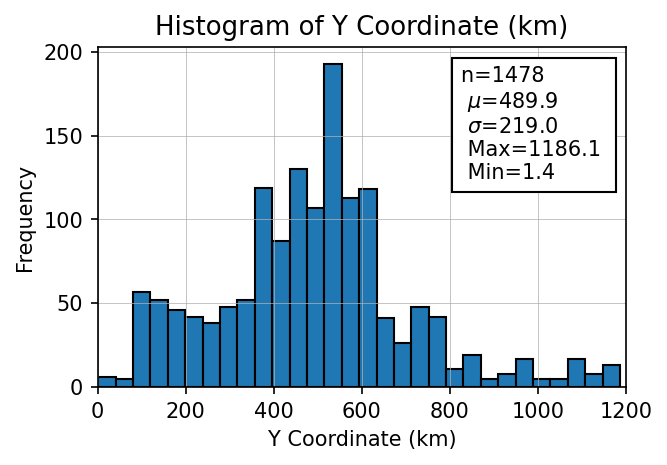

In [86]:
font = {'size'   : 10} #10 changes the font size of#s in ur plot
matplotlib.rc('font', **font)
fig = plt.subplots(figsize=(10, 3), dpi= 150, facecolor='w', edgecolor='k')#dpi makesplot small, dpi=100 to begin with

ax2=plt.subplot(1,2,2) 
val=df['Y Coordinate (km)']
histplt(val,bins=30,title='Histogram of Y Coordinate (km)',xlabl='Y Coordinate (km)',xlimt=(0,1200),axt=ax2)

Even though both the graphs have the same number of data poits, X Coordinate has a lower mean and lower standard deviation as compared to Y axis. The max values for the Y coordinate histogram are higher than X coordinate.
X Coordiante histogram is skewed towards right i.e. it depicts as negatively skewed distribution.
On the contary, Y Coordinate histogram depicts a uniform distribution.

**IMPUTATION**

Applying imputation to missing values in emission dataset Note that imputation is not applied to text data, or to target data. The target data has already been removed so we ust need to remove the text variable - Abandoned (True/False) from the dataset.



Column - Abandoned (True/False) has been removed from the  datatset.

In [36]:
df2 = X_train.copy()
df2 = X_train.drop(["Abandoned (True/False)" ], axis=1)# for ordinal encoding
df2

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,294.3,548.7,2504.7,47.479024,NaN,177.8,84776.5,0.0
1,611.4,448.0,870.7,19.626487,48.7,177.8,10270.5,0.0
2,407.2,176.2,3269.1,NaN,35.7,139.7,23327.1,533.0
3,480.2,478.5,1102.3,NaN,NaN,114.3,138.0,0.0
4,379.7,638.8,1953.6,48.966279,35.7,114.3,59959.4,616.0
...,...,...,...,...,...,...,...,...
1177,385.7,615.9,603.3,NaN,NaN,114.3,54822.2,323.0
1178,604.5,483.0,610.0,NaN,53.6,177.8,32683.5,0.0
1179,601.1,517.9,NaN,NaN,48.1,177.8,851.4,0.0
1180,348.7,697.9,600.2,NaN,81.1,177.8,15003.3,438.0


Column - Abandoned (True/False) has been removed from the df2 datatset.

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   X Coordinate (km)             1182 non-null   float64
 1   Y Coordinate (km)             1182 non-null   float64
 2   Measured Depth (m)            857 non-null    float64
 3   Deviation (deg)               439 non-null    float64
 4   Surface-Casing Weight (kg/m)  900 non-null    float64
 5   Production-Casing Size (mm)   1097 non-null   float64
 6   Cumulative GAS Prod. (e3m3)   1108 non-null   float64
 7   Month Well Spudded            1182 non-null   float64
dtypes: float64(8)
memory usage: 74.0 KB


All variables except X Coordinate (km), Y Coordinate (km) and Month Well Spudded neeed to be imputed.

Imputation has been applied on the entire dataset and not just on the columns that are mising values as it does not matter. Also median has been chosen as the imputation measurement. Applying median on all the numerical values. We will apply this same imputation on the target dataset.

In [38]:
from sklearn.impute import SimpleImputer

imput_mdn = SimpleImputer(strategy="median") 

In [39]:
imput_mdn.fit(df2) # fit is the function u called to ur data set #imput_mdn is now a new dataset following fit
imput_mdn.statistics_# after fitting it will calculate the statics that u chose in SimpleImputer # statics is the mean, mean of all features

array([ 500.8       ,  493.4       , 1104.9       ,   33.17004428,
         35.7       ,  139.7       , 5005.4       ,    0.        ])

In [40]:
im = imput_mdn.transform(df2)

In [41]:
im

array([[2.94300e+02, 5.48700e+02, 2.50470e+03, ..., 1.77800e+02,
        8.47765e+04, 0.00000e+00],
       [6.11400e+02, 4.48000e+02, 8.70700e+02, ..., 1.77800e+02,
        1.02705e+04, 0.00000e+00],
       [4.07200e+02, 1.76200e+02, 3.26910e+03, ..., 1.39700e+02,
        2.33271e+04, 5.33000e+02],
       ...,
       [6.01100e+02, 5.17900e+02, 1.10490e+03, ..., 1.77800e+02,
        8.51400e+02, 0.00000e+00],
       [3.48700e+02, 6.97900e+02, 6.00200e+02, ..., 1.77800e+02,
        1.50033e+04, 4.38000e+02],
       [5.02600e+02, 1.40000e+00, 1.10490e+03, ..., 1.14300e+02,
        7.63000e+01, 0.00000e+00]])

In [42]:
X_train_im = pd.DataFrame(im, columns=df2.columns)#numpy(nmerical data) to pd 
#im is numerical dataframe,#Oil_Prod_num.columns -apply on all the column of the newly created data-oil_prod_num(without any categorical values)
#im numerical data frame and convert it to pandas 
#pandas as before imputation
X_train_im

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,294.3,548.7,2504.7,47.479024,35.7,177.8,84776.5,0.0
1,611.4,448.0,870.7,19.626487,48.7,177.8,10270.5,0.0
2,407.2,176.2,3269.1,33.170044,35.7,139.7,23327.1,533.0
3,480.2,478.5,1102.3,33.170044,35.7,114.3,138.0,0.0
4,379.7,638.8,1953.6,48.966279,35.7,114.3,59959.4,616.0
...,...,...,...,...,...,...,...,...
1177,385.7,615.9,603.3,33.170044,35.7,114.3,54822.2,323.0
1178,604.5,483.0,610.0,33.170044,53.6,177.8,32683.5,0.0
1179,601.1,517.9,1104.9,33.170044,48.1,177.8,851.4,0.0
1180,348.7,697.9,600.2,33.170044,81.1,177.8,15003.3,438.0


In [43]:
X_train_im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   X Coordinate (km)             1182 non-null   float64
 1   Y Coordinate (km)             1182 non-null   float64
 2   Measured Depth (m)            1182 non-null   float64
 3   Deviation (deg)               1182 non-null   float64
 4   Surface-Casing Weight (kg/m)  1182 non-null   float64
 5   Production-Casing Size (mm)   1182 non-null   float64
 6   Cumulative GAS Prod. (e3m3)   1182 non-null   float64
 7   Month Well Spudded            1182 non-null   float64
dtypes: float64(8)
memory usage: 74.0 KB


CONCLUSION - All the values have been replaced with median


**ONE HOT ENCODING THE NUMBERICAL COLUMN - Abandoned (True/False)**

One Hot Encoding has been selected for the  Abandoned (True/False) column as True and False.

In [44]:
Abandoned_cat = X_train[['Abandoned (True/False)']]
Abandoned_cat[0:10]

,Abandoned (True/False)
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,0.0


In [45]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
Abandoned_cat_2hot = cat_encoder.fit_transform(Abandoned_cat) # fit_trasfer of data 
Abandoned_cat_toarray_2=Abandoned_cat_2hot.toarray()#NUMPY TO ARRAY
Abandoned_cat_toarray_2[0:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

**STANDARDIZATION OF IMPUTED VARIABLES**

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()#call StandardScaler.
X_train_im_Std=scaler.fit_transform(X_train_im)#fit transform
X_train_im_Std

array([[-0.83487717,  0.27013885,  1.45281486, ...,  1.39593683,
         0.13719989, -0.7320854 ],
       [ 0.97223857, -0.19362726, -0.57425854, ...,  1.39593683,
        -0.21711555, -0.7320854 ],
       [-0.1914733 , -1.44538127,  2.40109816, ..., -0.13971303,
        -0.15502451,  1.41005972],
       ...,
       [ 0.91354008,  0.12829182, -0.28371962, ...,  1.39593683,
        -0.26190835, -0.7320854 ],
       [-0.52485795,  0.95726798, -0.90982975, ...,  1.39593683,
        -0.19460858,  1.02825149],
       [ 0.35220012, -2.25040924, -0.28371962, ..., -1.1634796 ,
        -0.26559436, -0.7320854 ]])

In [47]:
X_train_im_Std.mean()

3.214198976537467e-16

In [48]:
X_train_im_Std.std()

1.0

The mean is 0 and the standard deviation is 1 for the new X_train dataset. So, the X_train dataset is now stanrdardized.

In [49]:
X_train_im_Std = pd.DataFrame(X_train_im_Std, columns=X_train_im.columns)#numpy(nmerical data) to pd 
#im is numerical dataframe,#X_train_im.columns -use those column names for the newly created data
#im numerical data frame and convert it to pandas 
X_train_im_Std

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,-0.834877,0.270139,1.452815,1.283786,-0.410919,1.395937,0.137200,-0.732085
1,0.972239,-0.193627,-0.574259,-1.151244,0.745630,1.395937,-0.217116,-0.732085
2,-0.191473,-1.445381,2.401098,0.032812,-0.410919,-0.139713,-0.155025,1.410060
3,0.224545,-0.053162,-0.286945,0.032812,-0.410919,-1.163480,-0.265301,-0.732085
4,-0.348193,0.685087,0.769143,1.413811,-0.410919,-1.163480,0.019181,1.743640
...,...,...,...,...,...,...,...,...
1177,-0.313999,0.579623,-0.905984,0.032812,-0.410919,-1.163480,-0.005249,0.566063
1178,0.932916,-0.032437,-0.897672,0.032812,1.181560,1.395937,-0.110530,-0.732085
1179,0.913540,0.128292,-0.283720,0.032812,0.692251,1.395937,-0.261908,-0.732085
1180,-0.524858,0.957268,-0.909830,0.032812,3.628106,1.395937,-0.194609,1.028251


**CONCATANATION of STANRARDIZED DATA AND ONE-HOT ENCODNG column**

In [98]:
concatenated_X_train=np.concatenate((X_train_im_Std, Abandoned_cat_toarray_2), axis=1)# concanate columns together
#X_train_im_Std is just created above
concatenated_X_train[0:4]

array([[-0.83487717,  0.27013885,  1.45281486,  1.28378614, -0.41091886,
         1.39593683,  0.13719989, -0.7320854 ,  1.        ,  0.        ],
       [ 0.97223857, -0.19362726, -0.57425854, -1.15124352,  0.74563013,
         1.39593683, -0.21711555, -0.7320854 ,  1.        ,  0.        ],
       [-0.1914733 , -1.44538127,  2.40109816,  0.03281248, -0.41091886,
        -0.13971303, -0.15502451,  1.41005972,  0.        ,  1.        ],
       [ 0.22454514, -0.05316186, -0.28694507,  0.03281248, -0.41091886,
        -1.1634796 , -0.26530094, -0.7320854 ,  0.        ,  1.        ]])

In [154]:
X_train_new = pd.DataFrame(concatenated_X_train)
X_train_new [0:10]

,0,1,2,3,4,5,6,7,8,9
0,-0.834877,0.270139,1.452815,1.283786,-0.410919,1.395937,0.137200,-0.732085,1.0,0.0
1,0.972239,-0.193627,-0.574259,-1.151244,0.745630,1.395937,-0.217116,-0.732085,1.0,0.0
2,-0.191473,-1.445381,2.401098,0.032812,-0.410919,-0.139713,-0.155025,1.410060,0.0,1.0
3,0.224545,-0.053162,-0.286945,0.032812,-0.410919,-1.163480,-0.265301,-0.732085,0.0,1.0
4,-0.348193,0.685087,0.769143,1.413811,-0.410919,-1.163480,0.019181,1.743640,0.0,1.0
5,0.530575,-1.241822,3.512887,0.911871,-0.410919,1.395937,-0.110530,-0.732085,0.0,1.0
6,-0.949425,0.482909,2.543887,0.882627,-0.410919,-0.139713,1.670498,2.207436,0.0,1.0
7,-1.167692,-0.004344,-0.283720,0.427193,0.113976,-0.139713,-0.110530,3.005616,0.0,1.0
8,0.935196,0.254480,1.807739,0.032812,-0.410919,1.395937,-0.110530,1.420911,0.0,1.0
9,0.440533,0.759235,-0.283720,-2.730205,-1.336158,-1.163480,-0.265762,-0.732085,1.0,0.0


In [155]:
X_train_new = X_train_new.rename({0: 'X Coordinate (km)', 1: 'Y Coordinate (km)', 2: 'Measured Depth (m)', 3: 'Deviation (deg)', 4: 'Surface-Casing Weight (kg/m)', 5: 'Production-Casing Size (mm)',6: 'Cumulative GAS Prod. (e3m3)',7: 'Month Well Spudded', 8: 'Abandoned (False)' , 9: 'Abandoned (True)'}, axis=1)

X_train_new

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Abandoned (False),Abandoned (True)
0,-0.834877,0.270139,1.452815,1.283786,-0.410919,1.395937,0.137200,-0.732085,1.0,0.0
1,0.972239,-0.193627,-0.574259,-1.151244,0.745630,1.395937,-0.217116,-0.732085,1.0,0.0
2,-0.191473,-1.445381,2.401098,0.032812,-0.410919,-0.139713,-0.155025,1.410060,0.0,1.0
3,0.224545,-0.053162,-0.286945,0.032812,-0.410919,-1.163480,-0.265301,-0.732085,0.0,1.0
4,-0.348193,0.685087,0.769143,1.413811,-0.410919,-1.163480,0.019181,1.743640,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1177,-0.313999,0.579623,-0.905984,0.032812,-0.410919,-1.163480,-0.005249,0.566063,0.0,1.0
1178,0.932916,-0.032437,-0.897672,0.032812,1.181560,1.395937,-0.110530,-0.732085,0.0,1.0
1179,0.913540,0.128292,-0.283720,0.032812,0.692251,1.395937,-0.261908,-0.732085,0.0,1.0
1180,-0.524858,0.957268,-0.909830,0.032812,3.628106,1.395937,-0.194609,1.028251,0.0,1.0


# Model Training and Evaluation

# <span style='color:blue'>LINEAR REGRESSION </span> 

In [63]:
from sklearn.linear_model import LinearRegression # call functopn
from sklearn.model_selection import cross_val_score

clf= LinearRegression()#call linear regression
clf.fit(X_train_new,y_train) # fit ur final data that is standaized and one hot coded(look above) and ur target


LinearRegression()

In [64]:
neg_mse=cross_val_score(clf,X_train_new,y_train, cv=5, scoring="neg_mean_squared_error")
linear_rmse_scores = np.sqrt(-neg_mse)
linear_rmse = np.mean(linear_rmse_scores)
linear_rmse

8.226802076502988

 <span style='color:red'>Root mean square error is 8.22 for the Linear Regression. </span>  

# <span style='color:blue'>SUPPORT VECTOR MACHINE-POLYNOMINAL KERNEL Fine-tune 'degree', 'coef0', 'C'.</span> 

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import randint

np.random.seed(42)
model = SVR() 

param_grid = [{
'kernel': ['poly'], 'C' : randint(low=0.001, high=200),'degree': randint(low=1, high=20),
    'coef0' : randint(low=0, high=2)
               }]

gs = RandomizedSearchCV(model,param_grid,cv=5, n_iter = 40, scoring="neg_mean_squared_error",random_state = 42 , n_jobs=5)
gs.fit(X_train_new, y_train)
gs.best_params_

{'C': 8, 'coef0': 1, 'degree': 1, 'kernel': 'poly'}

In [67]:
cvreslt=gs.cv_results_

cvreslt_params=[str(i) for i in cvreslt["params"]]

for mean_score, params in sorted(zip(cvreslt["mean_test_score"], cvreslt_params)):

    print(np.mean(np.sqrt(-mean_score)), params)

1372761.061177661 {'C': 80, 'coef0': 1, 'degree': 18, 'kernel': 'poly'}
744030.1626004053 {'C': 40, 'coef0': 0, 'degree': 15, 'kernel': 'poly'}
675158.9069915994 {'C': 3, 'coef0': 1, 'degree': 18, 'kernel': 'poly'}
270434.3642497996 {'C': 187, 'coef0': 1, 'degree': 15, 'kernel': 'poly'}
270309.23074748367 {'C': 189, 'coef0': 1, 'degree': 15, 'kernel': 'poly'}
242670.55834496237 {'C': 102, 'coef0': 1, 'degree': 15, 'kernel': 'poly'}
237361.70435408133 {'C': 94, 'coef0': 1, 'degree': 15, 'kernel': 'poly'}
216268.02770941175 {'C': 83, 'coef0': 1, 'degree': 15, 'kernel': 'poly'}
150170.8909070886 {'C': 81, 'coef0': 0, 'degree': 13, 'kernel': 'poly'}
130793.89742740279 {'C': 189, 'coef0': 0, 'degree': 12, 'kernel': 'poly'}
129414.40848386116 {'C': 187, 'coef0': 0, 'degree': 12, 'kernel': 'poly'}
128290.47924796505 {'C': 189, 'coef0': 1, 'degree': 14, 'kernel': 'poly'}
67884.22660097026 {'C': 88, 'coef0': 1, 'degree': 14, 'kernel': 'poly'}
32889.66450899508 {'C': 121, 'coef0': 0, 'degree': 1

In [ ]:
METHOD 1

In [68]:
from sklearn.pipeline import Pipeline
clf = Pipeline([("svm_clf",SVR(kernel="poly", degree=1, coef0=1, C=8))])
clf.fit(X_train_new,y_train)

neg_rmse=cross_val_score(clf,X_train_new,y_train, cv=5, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-neg_rmse)
np.mean(rmse_scores)

8.224762598388708

In [ ]:
METHOD 2

In [69]:
clf = SVR(kernel="poly", degree=1, coef0=1, C=8)
clf.fit(X_train_new,y_train)

neg_rmse=cross_val_score(clf,X_train_new,y_train, cv=5, scoring="neg_root_mean_squared_error")
svm_poly_scores = (-neg_rmse)
svm_poly_rmse = np.mean(svm_poly_scores)
svm_poly_rmse

8.224762598388708

 <span style='color:red'>The RMSE is 8.22 for Support Vector Machine - Polynominal </span>  

# <span style='color:blue'>Decision Tree - Fine-tune 'max_depth','min_samples_split','min_samples_leaf'.</span> 

In [71]:
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint

np.random.seed(42)
model = DecisionTreeRegressor(random_state=42)

import warnings
warnings.filterwarnings('ignore')

param_grid = [{
'max_depth': randint(low=1, high=100),'min_samples_leaf': randint(low=0.0001, high=10), 
    'min_samples_split': randint(low=0.0001, high=10)
               }]
gs = RandomizedSearchCV(model,param_grid,cv=5, n_iter = 1000, scoring="neg_mean_squared_error",random_state=42)
gs.fit(X_train_new, y_train)
gs.best_params_

{'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 9}

In [91]:
cvreslt=gs.cv_results_

cvreslt_params=[str(i) for i in cvreslt["params"]]

for mean_score, params in sorted(zip(cvreslt["mean_test_score"], cvreslt_params)):

    print(np.mean(np.sqrt(-mean_score)), params)

9.940344366143998 {'max_depth': 80, 'min_samples_leaf': 1, 'min_samples_split': 4}
9.548633998249489 {'max_depth': 53, 'min_samples_leaf': 1, 'min_samples_split': 7}
9.384889789635782 {'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 5}
9.352359849323955 {'max_depth': 86, 'min_samples_leaf': 1, 'min_samples_split': 9}
9.352359849323955 {'max_depth': 90, 'min_samples_leaf': 1, 'min_samples_split': 9}
9.300212965859854 {'max_depth': 52, 'min_samples_leaf': 3, 'min_samples_split': 4}
9.300212965859854 {'max_depth': 58, 'min_samples_leaf': 3, 'min_samples_split': 6}
9.239942949410853 {'max_depth': 77, 'min_samples_leaf': 2, 'min_samples_split': 6}
9.190607427535936 {'max_depth': 62, 'min_samples_leaf': 3, 'min_samples_split': 7}
8.93831336138029 {'max_depth': 99, 'min_samples_leaf': 4, 'min_samples_split': 2}
8.900458572909324 {'max_depth': 33, 'min_samples_leaf': 4, 'min_samples_split': 9}
8.872995084270523 {'max_depth': 79, 'min_samples_leaf': 5, 'min_samples_split': 7}
8.635

nan {'max_depth': 78, 'min_samples_leaf': 9, 'min_samples_split': 1}
8.281343467140351 {'max_depth': 16, 'min_samples_leaf': 9, 'min_samples_split': 3}
8.281343467140351 {'max_depth': 85, 'min_samples_leaf': 9, 'min_samples_split': 7}
nan {'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 1}
8.302544569510529 {'max_depth': 15, 'min_samples_leaf': 8, 'min_samples_split': 3}
nan {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 1}
8.281343467140351 {'max_depth': 42, 'min_samples_leaf': 9, 'min_samples_split': 7}
nan {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 0}
10.004221889198623 {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 2}
10.004221889198623 {'max_depth': 85, 'min_samples_leaf': 1, 'min_samples_split': 2}
10.004221889198623 {'max_depth': 89, 'min_samples_leaf': 1, 'min_samples_split': 2}
9.940344366143998 {'max_depth': 55, 'min_samples_leaf': 1, 'min_samples_split': 4}
9.686436254036705 {'max_depth': 87, 'min_samples_leaf': 1,

In [92]:
clf = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=5, random_state = 42)
clf.fit(X_train_new,y_train)

neg_rmse=cross_val_score(clf,X_train_new,y_train, cv=5, scoring="neg_mean_squared_error")
dt_rmse_scores = np.sqrt(-neg_rmse)
dt_rmse = np.mean(dt_rmse_scores)
dt_rmse

7.600048737727536

 <span style='color:red'> Applying decion tree algorithim results in further lower rmse of 7.6 as compared to all the algorithims run so far. </span>   

# <span style='color:blue'>RANDOM FOREST Fine-tune 'n_estimators','max_depth','min_samples_split','bootstrap'.</span> 

In [93]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
np.random.seed(42)
model_rnd = RandomForestRegressor(random_state =42)
import warnings
warnings.filterwarnings('ignore')

param_grid = [{
'max_depth': randint(low=1, high=100),'n_estimators': randint(low=0.1, high=1000), 'min_samples_split': randint(low=0.1, high=10),'bootstrap': [True, False]
               }]
gs = RandomizedSearchCV(model_rnd,param_grid,cv=5, n_iter = 100, scoring="neg_mean_squared_error", random_state =42)
gs.fit(X_train_new, y_train)
gs.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'min_samples_split': 2,
 'n_estimators': 205}

In [94]:
cvreslt=gs.cv_results_

cvreslt_params=[str(i) for i in cvreslt["params"]]

for mean_score, params in sorted(zip(cvreslt["mean_test_score"], cvreslt_params)):

    print(np.mean(np.sqrt(-mean_score)), params)

9.773700854838218 {'bootstrap': False, 'max_depth': 71, 'min_samples_split': 2, 'n_estimators': 85}
9.762174332109986 {'bootstrap': False, 'max_depth': 80, 'min_samples_split': 2, 'n_estimators': 875}
9.755417607629889 {'bootstrap': False, 'max_depth': 24, 'min_samples_split': 2, 'n_estimators': 661}
9.737567381488464 {'bootstrap': False, 'max_depth': 74, 'min_samples_split': 3, 'n_estimators': 269}
9.737105212893177 {'bootstrap': False, 'max_depth': 96, 'min_samples_split': 3, 'n_estimators': 733}
9.736296346286206 {'bootstrap': False, 'max_depth': 28, 'min_samples_split': 3, 'n_estimators': 797}
9.693623477235462 {'bootstrap': False, 'max_depth': 82, 'min_samples_split': 4, 'n_estimators': 791}
9.693314875080844 {'bootstrap': False, 'max_depth': 57, 'min_samples_split': 4, 'n_estimators': 645}
9.520685219690034 {'bootstrap': False, 'max_depth': 60, 'min_samples_split': 6, 'n_estimators': 427}
9.48223176533908 {'bootstrap': False, 'max_depth': 23, 'min_samples_split': 7, 'n_estimators

In [95]:
clf = RandomForestRegressor(bootstrap = True, max_depth=11, min_samples_split=8, n_estimators = 472, random_state = 42)
clf.fit(X_train_new,y_train)

neg_rmse=cross_val_score(clf,X_train_new,y_train, cv=5, scoring="neg_mean_squared_error")
rf_rmse_scores = np.sqrt(-neg_rmse)
rf_rmse = np.mean(rf_rmse_scores)
rf_rmse

7.30416219410449

 <span style='color:red'> The RMSE values of Randomforest classifer of 7.3 are is lower than decision tree </span>   

# <span style='color:blue'>ENSEMBLED TECHNQIUES</span> 

# <span style='color:blue'>Gradient Boosting. Fine-tune 'n_estimators','learning_rate','algorithm' </span> 

**XGBoost stands for "Extreme Gradient Boosting" and it is an implementation of gradient boosting trees algorithm. The XGBoost is a popular supervised machine learning model with characteristics like computation speed, parallelization, and performance.**

In [100]:
import xgboost as xgb
from scipy.stats import randint
np.random.seed(42)
model = xgb.XGBRegressor(random_state=42)
import warnings
warnings.filterwarnings('ignore')

param_grid = [{
'learning_rate': randint(low=0.1, high=20),'n_estimators': randint(low=0.1, high=20), 'algorithm': ['SAMME', 'SAMME.R']
               }]
gs = RandomizedSearchCV(model,param_grid,cv=5, n_iter = 150, scoring="neg_mean_squared_error",random_state=42)
gs.fit(X_train_new, y_train)
gs.best_params_

[04:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

[04:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 4}

In [101]:
cvreslt=gs.cv_results_

cvreslt_params=[str(i) for i in cvreslt["params"]]

for mean_score, params in sorted(zip(cvreslt["mean_test_score"], cvreslt_params)):

    print(np.mean(np.sqrt(-mean_score)), params)

2.73454663618181e+23 {'algorithm': 'SAMME.R', 'learning_rate': 15, 'n_estimators': 19}
2.73454663618181e+23 {'algorithm': 'SAMME.R', 'learning_rate': 15, 'n_estimators': 19}
1.9554609293557265e+22 {'algorithm': 'SAMME.R', 'learning_rate': 15, 'n_estimators': 18}
1.9554609293557265e+22 {'algorithm': 'SAMME.R', 'learning_rate': 15, 'n_estimators': 18}
5.149150700993892e+21 {'algorithm': 'SAMME', 'learning_rate': 14, 'n_estimators': 18}
2.2454455673994276e+21 {'algorithm': 'SAMME.R', 'learning_rate': 18, 'n_estimators': 16}
3.0292167318549614e+20 {'algorithm': 'SAMME', 'learning_rate': 16, 'n_estimators': 16}
3.0292167318549614e+20 {'algorithm': 'SAMME.R', 'learning_rate': 16, 'n_estimators': 16}
2.5323352782377232e+20 {'algorithm': 'SAMME.R', 'learning_rate': 12, 'n_estimators': 18}
1.0165177376983345e+20 {'algorithm': 'SAMME.R', 'learning_rate': 13, 'n_estimators': 17}
4.533068746289667e+19 {'algorithm': 'SAMME.R', 'learning_rate': 11, 'n_estimators': 18}
4.533068746289667e+19 {'algorit

In [102]:
clf = xgb.XGBRegressor(random_state=42,n_estimators=4, learning_rate=1, algorithm = 'SAMME.R')
clf.fit(X_train_new,y_train)

neg_rmse=cross_val_score(clf,X_train_new,y_train, cv=5, scoring="neg_mean_squared_error")
xgb_rmse_scores = np.sqrt(-neg_rmse)
xbg=np.mean(xgb_rmse_scores)
xbg

[04:08:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:08:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:08:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language

8.249335407812195

XBG is giving some warnings.

 <span style='color:red'> The gradient Boosting has the rmse of 8.25. </span>   

# <span style='color:blue'>SHALLOW NEURAL NETWORK </span> 

# EARLY STOPPING APPLIED

DIVING DATA INTO VALIDATION AND TRAINING FOR EARLY STOPPING

In [105]:
from sklearn.model_selection import train_test_split
# Smaller Training
# You need to divid your data to smaller training set and validation set for early stopping.
Training_c=np.concatenate((X_train_new,np.array(y_train).reshape(-1,1)),axis=1)
Smaller_Training, Validation = train_test_split(Training_c, test_size=0.15, random_state=42)
# to avoid overfittting or epoch

#
Smaller_Training_Target=Smaller_Training[:,-1]
Smaller_Training=Smaller_Training[:,:-1]
#
Validation_Target=Validation[:,-1]
Validation=Validation[:,:-1]

Lets now train a ANN for regression with 3 hidden layers; each layer has 50 neurons. Th following code implement early stopping to avoid overfitting.

In [106]:
def ANN (input_dim,neurons=50,loss="mse",activation="relu",Nout=1,
             metrics=None,activation_out=None,dropout_rate=True):
    """ Function to run Neural Network for different hyperparameters"""
    # activation_out='sigmoid' not needed for regression
    np.random.seed(42)
    tf.random.set_seed(42)

    # create model
    model = keras.models.Sequential()
    
    # Input and Hidden Layer 1
    model.add(keras.layers.Dense(neurons,input_dim=input_dim, activation=activation))
    
    # Hidden Layer 2
    model.add(keras.layers.Dense(neurons,activation=activation)) 
    
    # Hidden Layer 3
    model.add(keras.layers.Dense(neurons,activation=activation)) 
    
    # Output Layer 
    model.add(keras.layers.Dense(Nout,activation=activation_out)) 
    
    # Compile model
    model.compile(optimizer='adam',loss='mse',metrics=metrics)
    return model

In [107]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
import tensorflow as tf

# define the grid search parameters
param_grid = {
    'neurons' : [50,100,150,200],
    'activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    'dropout_rate' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
# Run Keras Classifier 
model = KerasRegressor(build_fn=ANN,input_dim=Smaller_Training.shape[1],loss='mse'
                        ,metrics=None,activation_out=None)
#model. _estimator_type = "regressor"
# loss use mse
# use KerasRegressor

# Apply Scikit Learn GridSearchCV
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=5)

# Early stopping to avoid overfitting
monitor= keras.callbacks.EarlyStopping(min_delta=1e-3,patience=5, verbose=0)
grid_result = grid.fit(Smaller_Training,Smaller_Training_Target,batch_size=32,validation_data=
                       (Validation,Validation_Target),callbacks=[monitor],
                   verbose=0,epochs=1000)

7/7 [==============================] - 0s 906us/step - loss: 81.1761


7/7 [==============================] - 0s 863us/step - loss: 70.4118


7/7 [==============================] - 0s 794us/step - loss: 93.4482


7/7 [==============================] - 0s 766us/step - loss: 84.9175


7/7 [==============================] - 0s 735us/step - loss: 80.6252


7/7 [==============================] - 0s 675us/step - loss: 55.5849


7/7 [==============================] - 0s 724us/step - loss: 72.2074


7/7 [==============================] - 0s 678us/step - loss: 76.6156


7/7 [==============================] - 0s 685us/step - loss: 88.7191


7/7 [==============================] - 0s 754us/step - loss: 83.0126


7/7 [==============================] - 0s 813us/step - loss: 78.0879


7/7 [==============================] - 0s 749us/step - loss: 78.2689


7/7 [==============================] - 0s 726us/step - loss: 92.2677


7/7 [==============================] - 0s 893us/step - loss: 72.0398


In [108]:
# Best result
print("Best parameters: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))

Best parameters: 8.125925 using {'activation': 'tanh', 'dropout_rate': 0.0, 'neurons': 100}


<span style='color:red'> The RMSE of shallow neural network with 3 hidden layers using k-fold cross-validation is is 8.13. </span>   

In [109]:
rmse_snn = np.sqrt(-grid_result.best_score_)

print("Accuracy for shallow neural network: " , rmse_snn)

Accuracy for shallow neural network:  8.125924770839788


**MAKING PLOTS USING SLECTED HYPERPARAMTERS**

In [110]:
clf_early=ANN (input_dim=Smaller_Training.shape[1],neurons=100,dropout_rate= 0.0,activation= 'tanh',
loss='mse',metrics=None,activation_out=None)  
    
# Early stopping to avoid overfitting
monitor= keras.callbacks.EarlyStopping(min_delta=1e-3,patience=5)
history=clf_early.fit(Smaller_Training,Smaller_Training_Target,batch_size=32,validation_data=
          (Validation,Validation_Target),callbacks=[monitor],verbose=1,epochs=1000)

Epoch 1/1000
32/32 [==============================] - 0s 5ms/step - loss: 2269.4485 - val_loss: 1725.4347
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 1377.6711 - val_loss: 1199.5297
Epoch 3/1000
32/32 [==============================] - 0s 3ms/step - loss: 1053.0566 - val_loss: 958.5938
Epoch 4/1000
32/32 [==============================] - 0s 3ms/step - loss: 845.8032 - val_loss: 775.1951
Epoch 5/1000
32/32 [==============================] - 0s 3ms/step - loss: 683.2059 - val_loss: 628.1581
Epoch 6/1000
32/32 [==============================] - 0s 3ms/step - loss: 552.9108 - val_loss: 509.7902
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 447.9984 - val_loss: 414.9404
Epoch 8/1000
32/32 [==============================] - 0s 3ms/step - loss: 363.7707 - val_loss: 338.6638
Epoch 9/1000
32/32 [==============================] - 0s 4ms/step - loss: 297.1128 - val_loss: 277.4570
Epoch 10/1000
32/32 [==============================] - 0s 3

In [111]:
def plot_NN(model,history,x_train,y_train):
    """ Plot training loss versus validation loss and 
    training accuracy versus validation accuracy"""
    
    font = {'size'   : 7.5}
    plt.rc('font', **font)
    fig, ax=plt.subplots(figsize=(7, 5), dpi= 200, facecolor='w', edgecolor='k')
    
    ax1 = plt.subplot(2,2,1)    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    ax1.plot(epochs, loss_values, 'bo',markersize=4, label='Training loss')          
    ax1.plot(epochs, val_loss_values, 'r-', label='Validation loss')    
    plt.title('Training and validation loss',fontsize=11)
    plt.xlabel('Epochs (Early Stopping)',fontsize=9)
    plt.ylabel('Loss',fontsize=10)
    plt.legend(fontsize='8.5')
    plt.ylim((0, 100))
    
    ax2 = plt.subplot(2,2,2)
    pred=model.predict(x_train)
    t = pd.DataFrame({'pred': pred.flatten(), 'y': y_train.flatten()})
    t.sort_values(by=['y'], inplace=True)    

    epochs = range(1, len(loss_values) + 1)        
    ax2.plot(t['pred'].tolist(), 'g', label='Prediction')    
    ax2.plot(t['y'].tolist(), 'm--o',markersize=2, label='Expected')      
    plt.title('Prediction vs Expected for Training',fontsize=11)
    plt.xlabel('Data',fontsize=9)
    plt.ylabel('Output',fontsize=10)
    plt.legend(fontsize='8.5')    
    fig.tight_layout(w_pad=1.42)
    plt.show()    

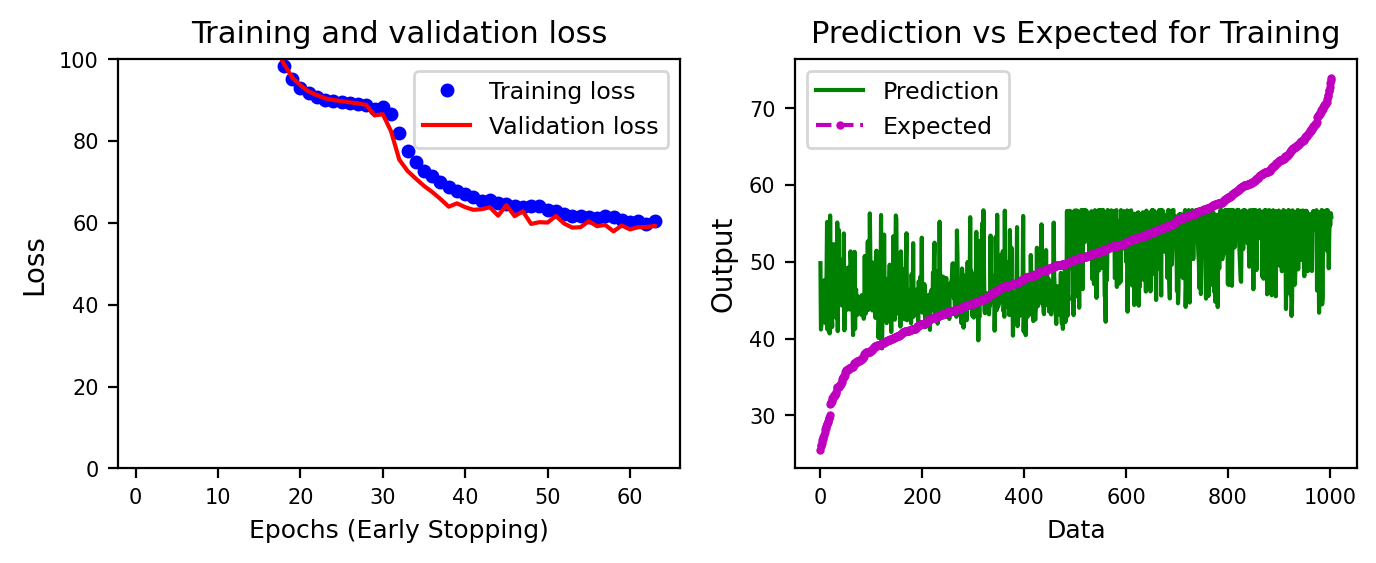

In [112]:
plot_NN(clf_early,history,Smaller_Training,Smaller_Training_Target)

<span style='color:red'> The plots show that as the training loss keeps on decreasing and the validation set loses  keep on decreasing until it starts increasing after epoch 64. The performance of the training set is higher than validation set since the validation data set has not been seen before. Also, we see the code stopped well at epoch 64 after which overfitting started.  </span>  

# NO EARLY STOPPING

In [113]:
def DNN (input_dim,neurons=50,loss="mse",activation="relu",Nout=1,L2_regularizer=False,
             metrics=None,activation_out=None,init_mode=None,BatchOpt=False,
             dropout_rate=True):
    """ Function to run Deep Neural Network (5 hidden layer) for different hyperparameters"""
    # neurons is 50
    # dropout_rate is false we are not appplying it 
    #batch optimization does not help that much
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if(activation=='Leaky_relu'): activation = keras.layers.LeakyReLU(alpha=0.2)
    if(L2_regularizer): kernel_regularizer=keras.regularizers.l2() 
    else: kernel_regularizer=None
        
    # create model
    model = keras.models.Sequential()
    
    # Input & Hidden Layer 1
    model.add(keras.layers.Dense(neurons,input_dim=input_dim, activation=activation, 
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
        
    # Hidden Layer 2
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
        
    # Hidden Layer 3    
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))                                 
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
      
    # Output Layer 
    model.add(keras.layers.Dense(Nout)) 
        
    # Compile model
    model.compile(optimizer='adam',loss='mse',metrics=metrics)
    return model

In [114]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')


# define the grid search parameters
#param_grid = {'init_mode' : ['he_normal', 'he_uniform'],'neurons' : [150,500,1000]
#             ,'dropout_rate' : [False,0.3, 0.4,0.5],'BatchOpt':[True,False],
#             'activation' : ['relu','elu', 'Leaky_relu'],'L2_regularizer':[True,False]}

param_grid = {'init_mode' : [None,'he_normal', 'he_uniform'],'neurons' : [50,100,150,200],'L2_regularizer':[True,False]
             ,'dropout_rate' : [True, 0.1,0.2, 0.3, 0.4,0.5,0.6],'activation': ['relu','elu', 'Leaky_relu']}

# Run Keras KerasRegressor
model = KerasRegressor(build_fn=DNN,input_dim=Smaller_Training.shape[1],metrics=None,
                        activation_out=None,loss='mse')

# Apply Scikit Learn RandomizedSearchCV
grid = RandomizedSearchCV(model,param_grid,n_iter=40,scoring='neg_mean_squared_error', cv=5)

# Early stopping to avoid overfitting
#monitor= keras.callbacks.EarlyStopping(min_delta=1e-3,patience=5, verbose=0)
grid_result = grid.fit(Smaller_Training,Smaller_Training_Target,batch_size=32,validation_data=
                       (Validation,Validation_Target),callbacks=False,verbose=0,epochs=200)

In [161]:
# Best result
print("Best parameters: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))

Best parameters: 8.125193 using {'neurons': 150, 'init_mode': None, 'dropout_rate': 0.2, 'activation': 'relu', 'L2_regularizer': False}


In [ ]:
Using the above hyper-paramters in making the plot below.

In [163]:
clf_no_early=ANN (input_dim=Smaller_Training.shape[1],neurons=150,dropout_rate= 0.2,activation= 'relu',
loss='mse',metrics=None,activation_out=None)  
    
# Early stopping to avoid overfitting
#monitor= keras.callbacks.EarlyStopping(min_delta=1e-3,patience=5)
history=clf_no_early.fit(Smaller_Training,Smaller_Training_Target,batch_size=32,validation_data=
          (Validation,Validation_Target),callbacks=False,verbose=0,epochs=200)

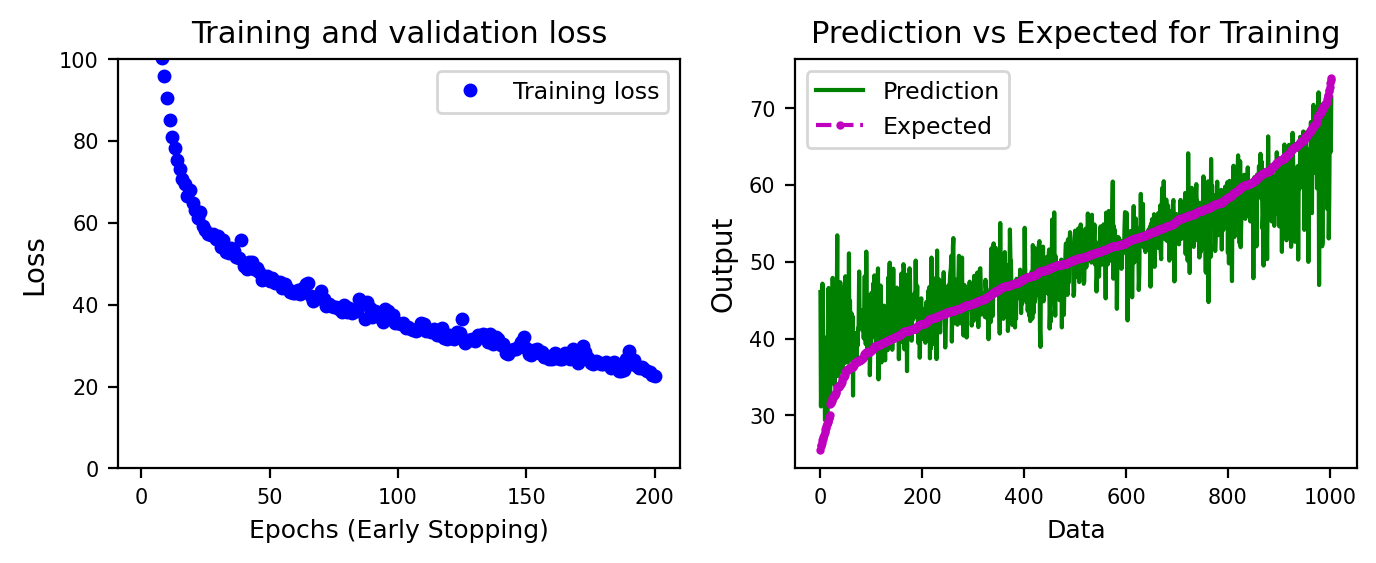

In [164]:
plot_NN(clf_no_early,history,Smaller_Training,Smaller_Training_Target)

<span style='color:red'> The plots are overfitting. The prediction is matching expectations very closely and it is clearly overfitting. The algorithims runs till epoch 200 since no early stopping has been applied and leads to overfitting.  </span>  

**PLOTTING THE PERFORMANCE OF ALL TRAINING DATASET**

In [118]:
clf_2=['Linear','poly_SVR','Decision_tree_regressor', 
     'Random_forest', 'Xg_booster',
       'shallow_nn' ]
    
acc_all=[np.mean(linear_rmse_scores),  np.mean(svm_poly_scores) , np.mean(dt_rmse_scores) ,  np.mean(rf_rmse_scores),
 np.mean(xgb_rmse_scores),rmse_snn]

for i,clfier in enumerate(acc_all):
    print(clf_2[i], acc_all[i])

Linear 8.226802076502988
poly_SVR 8.224762598388708
Decision_tree_regressor 7.600048737727536
Random_forest 7.30416219410449
Xg_booster 8.249335407812195
shallow_nn 8.125924770839788


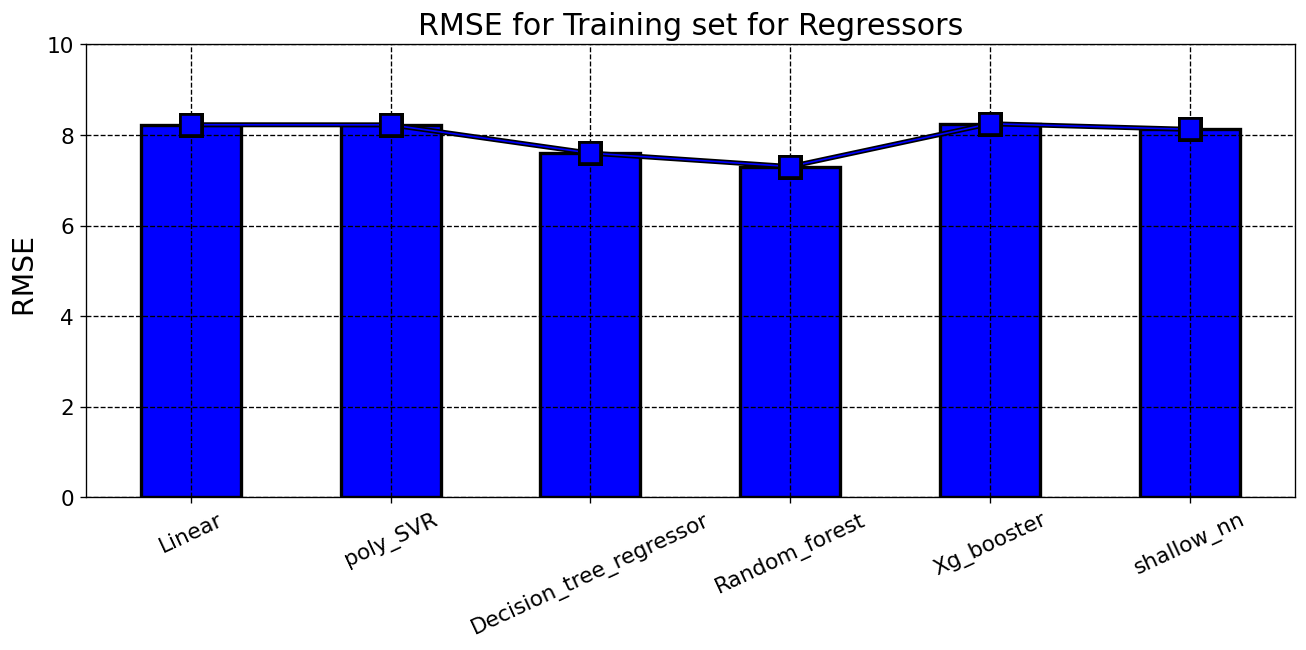

In [119]:
import matplotlib
import pylab as plt
import matplotlib.patheffects as pe
font = {'size'   :13}
matplotlib.rc('font', **font)
fig, ax1 = plt.subplots(figsize=(13, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(clf_2,acc_all,'bs-',linewidth=1,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()],
markersize=12,label='Accuracy',markeredgecolor='k')
ax1.bar(clf_2,acc_all,lw =2, align='center',width=0.5, alpha=1, ecolor='black', edgecolor='k',capsize=1
,color='b')
plt.ylim((0.0, 10.0))
ax1.set_xticklabels(clf_2, rotation=25)
ax1.xaxis.grid(color='k', linestyle='--', linewidth=0.8)
ax1.yaxis.grid(color='k', linestyle='--', linewidth=0.8)
plt.ylabel('RMSE ',fontsize='17')
plt.title('RMSE for Training set for Regressors',fontsize='18')
plt.show()

# FINDING THE BEST ALGORITHIM ON TRAINING DATASET

<span style='color:red'> The best algorithim on training data set is random forest.
</span> 

# TESTING

In [120]:
test_set_strat


,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Abandoned (True/False),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Emission Rate (m3/day)
0,530.3,392.4,1405.9,19.987480,False,35.7,114.3,15566.5,0.0,30.224588
1,639.1,460.6,3857.8,9.318762,True,62.5,NaN,42082.8,0.0,50.859624
2,368.7,294.5,608.4,NaN,True,53.6,177.8,7662.5,215.2,39.581295
3,482.3,214.1,NaN,NaN,False,29.8,114.3,32784.4,0.0,34.881033
4,608.4,581.5,522.3,NaN,False,48.1,177.8,6.9,176.0,38.266446
...,...,...,...,...,...,...,...,...,...,...
291,427.2,332.0,3679.2,53.879711,True,35.7,139.7,192982.0,846.3,55.194368
292,635.1,289.1,NaN,NaN,False,35.7,114.3,393.9,0.0,35.697085
293,488.6,426.7,1609.4,64.273276,True,NaN,139.7,32683.5,0.0,57.997863
294,242.5,575.4,NaN,NaN,False,53.6,177.8,799.0,89.3,35.645165


Removing target from test_set_strat

In [121]:
# Remove target
X_test = test_set_strat.drop("Emission Rate (m3/day)", axis=1) # test_set_strat = ?
y_test = test_set_strat["Emission Rate (m3/day)"].copy()

In [122]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   X Coordinate (km)             296 non-null    float64
 1   Y Coordinate (km)             296 non-null    float64
 2   Measured Depth (m)            199 non-null    float64
 3   Deviation (deg)               113 non-null    float64
 4   Abandoned (True/False)        296 non-null    bool   
 5   Surface-Casing Weight (kg/m)  222 non-null    float64
 6   Production-Casing Size (mm)   274 non-null    float64
 7   Cumulative GAS Prod. (e3m3)   283 non-null    float64
 8   Month Well Spudded            296 non-null    float64
dtypes: bool(1), float64(8)
memory usage: 18.9 KB


**IMPUTATION**

In [123]:
df3 = X_test.copy()
df3 = X_test.drop(["Abandoned (True/False)" ], axis=1)# for ordinal encoding
df3

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,530.3,392.4,1405.9,19.987480,35.7,114.3,15566.5,0.0
1,639.1,460.6,3857.8,9.318762,62.5,NaN,42082.8,0.0
2,368.7,294.5,608.4,NaN,53.6,177.8,7662.5,215.2
3,482.3,214.1,NaN,NaN,29.8,114.3,32784.4,0.0
4,608.4,581.5,522.3,NaN,48.1,177.8,6.9,176.0
...,...,...,...,...,...,...,...,...
291,427.2,332.0,3679.2,53.879711,35.7,139.7,192982.0,846.3
292,635.1,289.1,NaN,NaN,35.7,114.3,393.9,0.0
293,488.6,426.7,1609.4,64.273276,NaN,139.7,32683.5,0.0
294,242.5,575.4,NaN,NaN,53.6,177.8,799.0,89.3


Column - Abandoned (True/False) has been removed from the df3 datatset.

We are replacing the df3 data with the median imputator from training data.


In [124]:
im = imput_mdn.transform(df3)

In [125]:
im

array([[  530.3,   392.4,  1405.9, ...,   114.3, 15566.5,     0. ],
       [  639.1,   460.6,  3857.8, ...,   139.7, 42082.8,     0. ],
       [  368.7,   294.5,   608.4, ...,   177.8,  7662.5,   215.2],
       ...,
       [  488.6,   426.7,  1609.4, ...,   139.7, 32683.5,     0. ],
       [  242.5,   575.4,  1104.9, ...,   177.8,   799. ,    89.3],
       [  388. ,   813.3,  1104.9, ...,   114.3,  3973.2,     0. ]])

In [126]:
X_test_im = pd.DataFrame(im, columns=df3.columns)#numpy(nmerical data) to pd 
#im is numerical dataframe,#Oil_Prod_num.columns -apply on all the column of the newly created data-oil_prod_num(without any categorical values)
#im numerical data frame and convert it to pandas 
#pandas as before imputation
X_test_im

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,530.3,392.4,1405.9,19.987480,35.7,114.3,15566.5,0.0
1,639.1,460.6,3857.8,9.318762,62.5,139.7,42082.8,0.0
2,368.7,294.5,608.4,33.170044,53.6,177.8,7662.5,215.2
3,482.3,214.1,1104.9,33.170044,29.8,114.3,32784.4,0.0
4,608.4,581.5,522.3,33.170044,48.1,177.8,6.9,176.0
...,...,...,...,...,...,...,...,...
291,427.2,332.0,3679.2,53.879711,35.7,139.7,192982.0,846.3
292,635.1,289.1,1104.9,33.170044,35.7,114.3,393.9,0.0
293,488.6,426.7,1609.4,64.273276,35.7,139.7,32683.5,0.0
294,242.5,575.4,1104.9,33.170044,53.6,177.8,799.0,89.3


In [127]:
X_test_im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   X Coordinate (km)             296 non-null    float64
 1   Y Coordinate (km)             296 non-null    float64
 2   Measured Depth (m)            296 non-null    float64
 3   Deviation (deg)               296 non-null    float64
 4   Surface-Casing Weight (kg/m)  296 non-null    float64
 5   Production-Casing Size (mm)   296 non-null    float64
 6   Cumulative GAS Prod. (e3m3)   296 non-null    float64
 7   Month Well Spudded            296 non-null    float64
dtypes: float64(8)
memory usage: 18.6 KB


CONCLUSION - All the values have been replaced with median of training data

**ONE HOT ENCODING THE NUMBERICAL COLUMN - Abandoned (True/False)**

In [128]:
Oil_Prod_cat = X_test[["Abandoned (True/False)"]]
Oil_Prod_cat_2hot = cat_encoder.fit_transform(Oil_Prod_cat)#not using any statics
cat_hot_toarray_2=Oil_Prod_cat_2hot.toarray()

**STANDRADIZATION OF IMPUTED VARIABLES**

In [129]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()#call StandardScaler.
X_test_im_Std=scaler.transform(X_test_im)#fit transform
X_test_im_Std

array([[ 0.51005917, -0.44968879,  0.08968864, ..., -1.1634796 ,
        -0.19193026, -0.7320854 ],
       [ 1.13009763, -0.13559893,  3.13141524, ..., -0.13971303,
        -0.06583123, -0.7320854 ],
       [-0.41088029, -0.90055972, -0.89965716, ...,  1.39593683,
        -0.22951796,  0.13281071],
       ...,
       [ 0.27241576, -0.29172278,  0.34214239, ..., -0.13971303,
        -0.11052988, -0.7320854 ],
       [-1.1300793 ,  0.39310365, -0.28371962, ...,  1.39593683,
        -0.26215754, -0.37318567],
       [-0.30089185,  1.48873381, -0.28371962, ..., -1.1634796 ,
        -0.24706254, -0.7320854 ]])

In [130]:
X_test_im_Std.mean()

0.008559681012234888

In [131]:
X_test_im_Std.std()

1.0246366995249228

The mean is 0 and the standard deviation is 1 for the new X_train dataset. So, the X_train dataset is now stanrdardized.

In [132]:
X_test_im_Std = pd.DataFrame(X_test_im_Std, columns=X_test_im.columns)#numpy(nmerical data) to pd 
#im is numerical dataframe,#X_train_im.columns -use those column names for the newly created data
#im numerical data frame and convert it to pandas 
X_test_im_Std

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded
0,0.510059,-0.449689,0.089689,-1.119683,-0.410919,-1.163480,-0.191930,-0.732085
1,1.130098,-0.135599,3.131415,-2.052404,1.973351,-0.139713,-0.065831,-0.732085
2,-0.410880,-0.900560,-0.899657,0.032812,1.181560,1.395937,-0.229518,0.132811
3,0.236513,-1.270836,-0.283720,0.032812,-0.935814,-1.163480,-0.110050,-0.732085
4,0.955142,0.421197,-1.006469,0.032812,0.692251,1.395937,-0.265924,-0.024735
...,...,...,...,...,...,...,...,...
291,-0.077496,-0.727856,2.909851,1.843371,-0.410919,-0.139713,0.651774,2.669223
292,1.107302,-0.925429,-0.283720,0.032812,-0.410919,-1.163480,-0.264084,-0.732085
293,0.272416,-0.291723,0.342142,2.752037,-0.410919,-0.139713,-0.110530,-0.732085
294,-1.130079,0.393104,-0.283720,0.032812,1.181560,1.395937,-0.262158,-0.373186


**CONCATANATION of STANRARDIZED DATA AND ONE-HOT ENCODNG column**

In [133]:
concatenated_X_test=np.concatenate((X_test_im_Std, cat_hot_toarray_2), axis=1)# concanate columns together
#Oil_Prod_im_Std is just created above
concatenated_X_test[0:4]

array([[ 0.51005917, -0.44968879,  0.08968864, -1.11968349, -0.41091886,
        -1.1634796 , -0.19193026, -0.7320854 ,  1.        ,  0.        ],
       [ 1.13009763, -0.13559893,  3.13141524, -2.05240447,  1.97335136,
        -0.13971303, -0.06583123, -0.7320854 ,  0.        ,  1.        ],
       [-0.41088029, -0.90055972, -0.89965716,  0.03281248,  1.18156013,
         1.39593683, -0.22951796,  0.13281071,  0.        ,  1.        ],
       [ 0.2365128 , -1.27083574, -0.28371962,  0.03281248, -0.93581417,
        -1.1634796 , -0.11005004, -0.7320854 ,  1.        ,  0.        ]])

In [134]:
X_test_new = pd.DataFrame(concatenated_X_test)
X_test_new [0:10]

,0,1,2,3,4,5,6,7,8,9
0,0.510059,-0.449689,0.089689,-1.119683,-0.410919,-1.163480,-0.191930,-0.732085,1.0,0.0
1,1.130098,-0.135599,3.131415,-2.052404,1.973351,-0.139713,-0.065831,-0.732085,0.0,1.0
2,-0.410880,-0.900560,-0.899657,0.032812,1.181560,1.395937,-0.229518,0.132811,0.0,1.0
3,0.236513,-1.270836,-0.283720,0.032812,-0.935814,-1.163480,-0.110050,-0.732085,1.0,0.0
4,0.955142,0.421197,-1.006469,0.032812,0.692251,1.395937,-0.265924,-0.024735,1.0,0.0
5,-1.387099,0.242046,-1.157445,0.032812,-0.410919,-0.139713,-0.242154,-0.732085,1.0,0.0
6,0.569897,-1.587689,-0.575127,0.032812,-0.410919,-0.139713,-0.110530,-0.732085,1.0,0.0
7,0.427995,-0.150797,-0.283720,0.032812,-1.336158,-1.163480,-0.265544,-0.732085,0.0,1.0
8,0.815519,0.185860,-0.657748,-1.951699,1.181560,1.395937,-0.263484,0.353054,0.0,1.0
9,0.449651,-1.375379,0.545718,0.032812,-0.935814,-1.163480,-0.110530,0.939833,0.0,1.0


In [136]:
X_test_new = X_test_new.rename({0: 'X Coordinate (km)', 1: 'Y Coordinate (km)', 2: 'Measured Depth (m)', 3: 'Deviation (deg)', 4: 'Surface-Casing Weight (kg/m)', 5: 'Production-Casing Size (mm)',6: 'Cumulative GAS Prod. (e3m3)',7: 'Month Well Spudded', 8: 'Abandoned (True)' , 9: 'Abandoned (False)'}, axis=1)

X_test_new

,X Coordinate (km),Y Coordinate (km),Measured Depth (m),Deviation (deg),Surface-Casing Weight (kg/m),Production-Casing Size (mm),Cumulative GAS Prod. (e3m3),Month Well Spudded,Abandoned (False),Abandoned (True
0,0.510059,-0.449689,0.089689,-1.119683,-0.410919,-1.163480,-0.191930,-0.732085,1.0,0.0
1,1.130098,-0.135599,3.131415,-2.052404,1.973351,-0.139713,-0.065831,-0.732085,0.0,1.0
2,-0.410880,-0.900560,-0.899657,0.032812,1.181560,1.395937,-0.229518,0.132811,0.0,1.0
3,0.236513,-1.270836,-0.283720,0.032812,-0.935814,-1.163480,-0.110050,-0.732085,1.0,0.0
4,0.955142,0.421197,-1.006469,0.032812,0.692251,1.395937,-0.265924,-0.024735,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
291,-0.077496,-0.727856,2.909851,1.843371,-0.410919,-0.139713,0.651774,2.669223,0.0,1.0
292,1.107302,-0.925429,-0.283720,0.032812,-0.410919,-1.163480,-0.264084,-0.732085,1.0,0.0
293,0.272416,-0.291723,0.342142,2.752037,-0.410919,-0.139713,-0.110530,-0.732085,0.0,1.0
294,-1.130079,0.393104,-0.283720,0.032812,1.181560,1.395937,-0.262158,-0.373186,1.0,0.0


**TESTING CHECK**

In [139]:
from sklearn.metrics import mean_squared_error

Linear = LinearRegression()
Poly_SVR = SVR(kernel="poly", degree=1, coef0=1, C=8)
Decision_Tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=5, random_state = 42)

Random_Forest = RandomForestRegressor(bootstrap = True, max_depth=11, min_samples_split=8, n_estimators = 472, random_state = 42)


Gradient_Boosting = xgb.XGBRegressor(random_state=42,n_estimators=4, learning_rate=1, algorithm = 'SAMME.R')



clf=['Linear','Poly_SVR','Decision_Tree', 'Random_Forest', 
     'Gradient_Boosting' ]
i=0
pre_acc=[]
for clfier in (Linear,Poly_SVR,Decision_Tree, Random_Forest, 
               Gradient_Boosting):
    clfier.fit(X_test_new, y_test)
    y_pred = clfier.predict(X_test_new)
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt(mse)
    pre_acc.append(rmse)
    print(clf[i], rmse)
    i+=1

Linear 7.905395666497231
Poly_SVR 7.956015604512923
Decision_Tree 6.412660348431807
Random_Forest 4.0179602140221
[09:37:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { algorithm } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Gradient_Boosting 4.082089060864561


**Testing on shallow neural network**

In [140]:
pred=clf_early.predict(X_test_new)

mse= mean_squared_error(pred, y_test)
rmse_shallow= np.sqrt(mse)

print('rmse of shallow neural network on Test: ',rmse_shallow)

rmse of shallow neural network on Test:  7.936352956058528


<span style='color:red'> 
The accuracy of shallow neural network is lower than its accuracy on each the training data.
</span> 

# FINDING THE BEST ALGORITHIM FOR REGRESSION ON TEST DATA

<span style='color:red'> The best algorithims according to test data is random forest.</span> 

# CONCLUSION

 <span style='color:red'> 
I would suggest using random forest for future data as it giving the best performance among all the algorithims on both test and training data set.</span> 